In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as spt  
import numpy.fft as npt
import scipy.optimize as so 

In [3]:
def F(dt,Y, xlimt='none', xlimf='none', plot='yes', output='no', absolute='yes',norm='no'):
    #f=np.size(t)/(np.amax(t)-np.amin(t))*spt.fftfreq(np.size(t))
    t=np.arange(0,np.size(Y)*dt,dt)
    f=spt.fftfreq(np.size(Y),d=dt)
    if absolute=='no':                   #plotting non-absolute is better for composition
        if norm=='yes':                  #found code online normalised this way so added it as an optional parameter
            A=(spt.fft(Y))/np.size(t)
        if norm=='no':
            A=(spt.fft(Y))
    if absolute=='yes': #plotting absolute makes graphs more readible
        if norm=='yes':
            A=abs(spt.fft(Y))/np.size(t)
        if norm=='no':
            A=abs(spt.fft(Y))
    
    if plot=='yes':          #plotting after each fourier transform can be turned off for composition
        plt.subplot(1,2,1)
        plt.plot(t,Y,'.')
        plt.xlabel('Time(s)')
        if xlimt!='none':
            plt.xlim([-xlimt,xlimt])
        plt.ylabel('Magnitude')
        plt.title('Time Domain')
    
        plt.subplot(1,2,2)
        plt.plot(f,A,'.')
        if xlimf!='none':
            plt.xlim([-xlimf,xlimf])
        plt.xlabel('Frequency(hz)')
        plt.ylabel('Power')
        plt.title('Frequency Domain')
    if output=='yes':
        return A

def invF(dt,A,xlimf='none',xlimt='none', plot='yes', output='no', absolute='yes',norm='no', positiveoutput='no'): #same as last cell but for inverse transform
    n=np.size(A)
    f=spt.fftfreq(np.size(A),d=dt)
    t=np.arange(0,np.size(A)*dt/2,dt)
    #print(f)
    #print(t)
    #print(A)
    if absolute=='no':
        if norm=='yes':
            Y0=(spt.ifft(A))/np.size(f)
        if norm=='no':
            Y0=(spt.ifft(A))
    if absolute=='yes':
        if norm=='yes':    
            Y0=abs(spt.ifft(A))/np.size(f)
        if norm=='no':
            Y0=abs(spt.ifft(A))
    Y=[]
    for i in range(len(Y0)//2):      #only plots the positive part of the time domain since negative part does not have physical meaning
        Y.append(Y0[i])

    if plot=='yes':
        plt.subplot(1,2,1)
        plt.plot(f,A,'.')
        if xlimf!='none':
            plt.xlim([-xlimf,xlimf])
        plt.xlabel('Frequency(hz)')
        plt.ylabel('Power')
        plt.title('Frequency Domain')
    
        plt.subplot(1,2,2)
        plt.plot(t,Y,'.')
        if xlimt!='none':
            plt.xlim([0,xlimt])
        plt.xlabel('Time(s)')
        plt.ylabel('Magnitude')
        plt.title('Time Domain')
    
    if output=='yes':
        if positiveoutput=='yes':
            return Y
        else:
            return Y0              #negative part of time domain is necessary for further transformation

def P(f):  # model extracted from arXiv:1603.04461v1 figure 3
    return 0.1*f**(-7/3)

def noise(x,y,noisetype='log'):
    if noisetype=='log':
        b=-1
        while b<0:
            yO=y+np.random.normal(0,y,1)[0]
            b=yO
    if noisetype=='white':
        b=-1
        while b<0:
            yO=y+np.random.normal(0,1,1)[0]
            b=yO
    if noisetype=='pink':
        b=-1
        while b<0:
            yO=y+np.random.normal(0,1/x,1)[0]
            b=yO
    if noisetype=='brown':
        b=-1
        while b<0:
            yO=y+np.random.normal(0,(1/x**2),1)[0]
            b=yO
    return yO

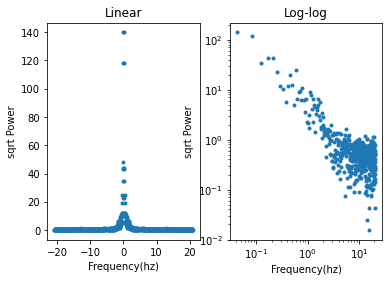

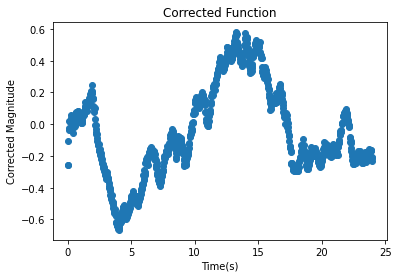

In [7]:
def gendata(n,q=0.1,dt=0.024,r=0.5):
    f=np.linspace(0.001,1,n)
    P0=P(f)
    rP0=np.sqrt(P0)
    ywn=[]
    for i in range(len(f)):
        if abs(f[i]<q):
            ywn.append(noise(f[i],rP0[i],noisetype='log'))
        else:
            ywn.append(noise(f[i],rP0[i],noisetype='white'))
    rP0=ywn
    rP1=[]    #adding imaginary part of frequency domain to model
    for i in range(len(rP0)):
        rP1.append(rP0[-i-1])
    rP=np.concatenate([rP1,rP0]) #for visual representation
    rPf=np.concatenate([rP0,rP1]) #for fft
    f=np.linspace(-1,1,2*n)
    dt=dt #0.024 (arXiv:1603.04461v1 caption of Figure 4 page 8)
    y=invF(dt,rPf,output='yes',plot='no',positiveoutput='yes')  #inverse fourier transform applied to model
    t=np.arange(0,np.size(rPf)*dt,dt)
    t=np.arange(0,np.size(rPf)*dt/2,dt)
    yy=[]
    tt=[]
    for i in range(len(t)):
        if t[i]<r:
            tt.append(t[i])
            yy.append(y[i])
    yy=np.array(yy)
    tt=np.array(tt)
    h=1/np.array(yy)
    def model(tt,A,B,C):
        Y=(abs(A*tt))**B+C
        return Y
    best_params, cov_matrix = so.curve_fit(model, xdata = tt, ydata = h, p0 = [0.1,0.5,100])
    def correction(t):
        O=1/((abs(best_params[0]*t))**best_params[1]+best_params[2])
        return O
    yc=[]
    for i in range(len(y)):
        yc.append(y[i]-correction(t[i]))
    yc[0]=yc[1]
    dt=dt
    Pc=F(dt,yc,output='yes',plot='no')
    f=spt.fftfreq(np.size(yc),d=dt)
    plt.subplot(1,2,1)
    plt.plot(f,Pc,'.')
    plt.title('Linear')
    plt.xlabel('Frequency(hz)')
    plt.ylabel('sqrt Power')

    plt.subplot(1,2,2)
    plt.loglog(f,Pc,'.')
    plt.title('Log-log')
    plt.xlabel('Frequency(hz)')
    plt.ylabel('sqrt Power')
    
    
    plt.figure()
    plt.scatter(t,yc)
    plt.xlabel('Time(s)')
    plt.ylabel('Corrected Magnitude')
    plt.title('Corrected Function')

gendata(1000,q=0.1,dt=0.024,r=0.5)